# Fine tune a checkpoint of MedSAM on point prompted Data

Given a path to a MedSAM checkpoint, we want to fine tune it on pre-processed data
(subject to modifications specified by the paper and the transformation script). This will
be done initially on an anatomy-specific level.

## Argparse Setup

In [226]:
# Imports
import re
import os
import cv2
import sys
import json
import torch
import monai
import random
import argparse
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from time import time, sleep
from datetime import datetime
from matplotlib import pyplot as plt
from segment_anything import sam_model_registry
from torch.utils.data import Dataset, DataLoader

# Add the setup_data_vars function as we will need it to find the directory for the training data.
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

In [227]:
parser = argparse.ArgumentParser()

# Inspired by orginal code from the MedSAM/extensions/point_prompt

# 1. Add the anatomy on which we will fine-tune
parser.add_argument(
    '--anatomy',
    type=str,
    help='Anatomy on which to fine-tune the model. Note: this is case sensitive, please capitalize the first letter and accronyms such as CTVn or CTVp.',
    required=True
)

# 2. Path to the MedSAM checkpoint
parser.add_argument(
    '--checkpoint',
    type=str,
    help='Path to the checkpoint of the model to fine-tune',
    required=True
)

# 3. Path where we will be saving the checkpoints of the fine-tuned model
parser.add_argument(
    '--save_dir',
    type=str,
    help='Directory where the fine-tuned model will be saved',
    required=True
)

# 4. Add the source directory for the data
parser.add_argument(
    '--img_dir',
    type=str,
    help='Directory containing the images for the slices of the anatomy',
    required=False,
)

# 5. Add the source directory for the gts
parser.add_argument(
    '--gt_dir',
    type=str,
    help='Directory containing the ground truth masks for the slices of the anatomy',
    required=False
)

# 6. Number of epochs for the fine-tuning
parser.add_argument(
    '--epochs',
    type=int,
    help='Number of epochs for the fine-tuning',
    required=False,
    default=300
)

# 7. Batch size for the fine-tuning
parser.add_argument(
    '--batch_size',
    type=int,
    help='Batch size for the fine-tuning',
    required=False,
    default=16
)

# 8. Learning rate for the fine-tuning
parser.add_argument(
    '--lr',
    type=float,
    help='Learning rate for the fine-tuning',
    required=False,
    default=0.00005
)

# 9. Number of workers for the data loader
parser.add_argument(
    '--num_workers',
    type=int,
    help='Number of workers for the data loader',
    required=False,
    default=16
)

parser.add_argument(
    '--weight_decay',
    type=float,
    help='Weight decay for the optimizer',
    required=False,
    default=0.01
)

# 11. Resume checkpoint
parser.add_argument(
    '--resume',
    type=bool,
    help='Whether to resume training using the latest checkpoint in the save_dir',
    required=False,
    default=True
)

_StoreAction(option_strings=['--resume'], dest='resume', nargs=None, const=None, default=True, type=<class 'bool'>, choices=None, required=False, help='Whether to resume training using the latest checkpoint in the save_dir', metavar=None)

In [228]:
# args = parser.parse_args()
# Suppose for now we get the following set of required arguments:
args = parser.parse_args([
    '--anatomy', 'Bladder',
    '--checkpoint', os.path.join(os.environ['PROJECT_DIR'], 'models', 'MedSAM', 'work_dir', 'MedSAM', 'medsam_vit_b.pth'),
    '--save_dir', os.path.join(os.environ['MedSAM_finetuned'], 'CTVn')
])

## Set up the vars

In [229]:
anatomy = args.anatomy
checkpoint_path = args.checkpoint
save_dir = args.save_dir
img_dir = args.img_dir
gt_dir = args.gt_dir
epochs = args.epochs
batch_size = args.batch_size
lr = args.lr
num_workers = args.num_workers
weight_decay = args.weight_decay
resume = args.resume

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [230]:
if img_dir is None:
    img_dir = os.path.join(os.environ['MedSAM_preprocessed'], 'imgs')
if gt_dir is None:
    gt_dir = os.path.join(os.environ['MedSAM_preprocessed'], 'gts', anatomy)

In [231]:
seed = 42

torch.cuda.empty_cache()
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [232]:
image_id_from_file_name_regex = r'.*_(\d+).*'
slice_id_from_file_name_regex = r'.*-(\d+).*'

## Set up Dataset class

In [233]:
# Adapted Dataset class from ../2_no_finetuning/MEDSAM_helper_functions.py
class SAM_Dataset(Dataset):
    """A torch dataset for delivering slices of any axis to a medsam model."""

    def __init__(self, img_path, gt_path, id_split, data_aug=False):
        """
        Args:
            img_path (string): Path to the directory containing the images
            gt_path (string): Path to the directory containing the ground truth masks
            id_split (list): List of image ids to include in the dataset
        """

        self.root_img_path = img_path
        self.root_gt_path = gt_path
        self.id_split = id_split
        self.data_aug = data_aug
        
        # Assume that axese 0 1 and 2 have been processed.
        filter_fn = lambda x : x.endswith('.npy') and int(re.search(image_id_from_file_name_regex, x).group(1)) in id_split
        self.axis0_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis0'))))
        self.axis1_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis1'))))
        self.axis2_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis2'))))

    def __len__(self):
        return len(self.axis0_imgs) + len(self.axis1_imgs) + len(self.axis2_imgs)

    def __getitem__(self, idx):
        assert 0 <= idx < self.__len__(), f"Index {idx} is out of range for dataset of size {self.__len__()}"

        # Fetch the image and ground truth mask. For safety, we index the items around the
        # ground truth masks, so that if for some reason the images are misaligned we will
        # guarantee that we will fetch the correct image

        if idx < len(self.axis0_imgs):
            axis, gt_name = 0, self.axis0_imgs[idx]
        elif idx < len(self.axis0_imgs) + len(self.axis1_imgs):
            axis, gt_name = 1, self.axis1_imgs[idx - len(self.axis0_imgs)]
        else:
            axis, gt_name = 2, self.axis2_imgs[idx - len(self.axis0_imgs) - len(self.axis1_imgs)]

        image_id = int(re.search(image_id_from_file_name_regex, gt_name).group(1))
        slice_id = int(re.search(slice_id_from_file_name_regex, gt_name).group(1))

        img_name = f'CT_zzAMLART_{image_id:03d}-{slice_id:03d}.npy'
        
        # Load the image and ground truth mask

        img_path = os.path.join(self.root_img_path, f'axis{axis}', img_name)
        gt_path = os.path.join(self.root_gt_path, f'axis{axis}', gt_name)

        img = np.load(img_path, 'r', allow_pickle=True) # (H, W, C)
        gt = np.load(gt_path, 'r', allow_pickle=True) # (H, W, C)

        # Pre-process where necessary

        img = np.transpose(img, (2, 0, 1)) # (C, H, W)
        assert np.max(img) <= 1. and np.min(img) >= 0., 'image should be normalized to [0, 1]'

        # add data augmentation: random fliplr and random flipud
        if self.data_aug:
            if random.random() > 0.5:
                img = np.ascontiguousarray(np.flip(img, axis=-1))
                gt = np.ascontiguousarray(np.flip(gt, axis=-1))
            if random.random() > 0.5:
                img = np.ascontiguousarray(np.flip(img, axis=-2))
                gt = np.ascontiguousarray(np.flip(gt, axis=-2))
        
        # Select a random point. We will use this point to guide the model to segment the
        # anatomy. The idea is that we want to select the center of this shape with
        # greater probability than the outside of the shape.
        gt = np.uint8(gt > 0)
        y_indices, x_indices = np.where(gt > 0)

        # Calculate the centroid of the segmentation
        centroid_x = np.mean(x_indices)
        centroid_y = np.mean(y_indices)

        # Calculate distances of each point from the centroid
        distances = np.sqrt((x_indices - centroid_x)**2 + (y_indices - centroid_y)**2)

        # Invert the distances to get higher probabilities for points closer to the
        # centroid
        inverse_distances = 1 / (distances + 1e-6)  # adding a small value to avoid division by zero

        # Normalize the probabilities
        probabilities = inverse_distances / np.sum(inverse_distances)

        # Sample a point based on the calculated probabilities
        index = np.random.choice(len(x_indices), p=probabilities)
        x_point = x_indices[index]
        y_point = y_indices[index]

        coords = np.array([x_point, y_point])

        # The output of the model is 256x256, and it is easier to reason about
        # constricting an image, rather than expanding the output back ot 1024x1024

        gt = cv2.resize(
            gt,
            (256, 256),
            interpolation=cv2.INTER_NEAREST
        )

        return {
            "image": torch.tensor(img).float(),
            "gt2D": torch.tensor(gt[None, :,:]).long(),
            "coords": torch.tensor(coords[None, ...]).float(),
            "image_name": img_name
        }

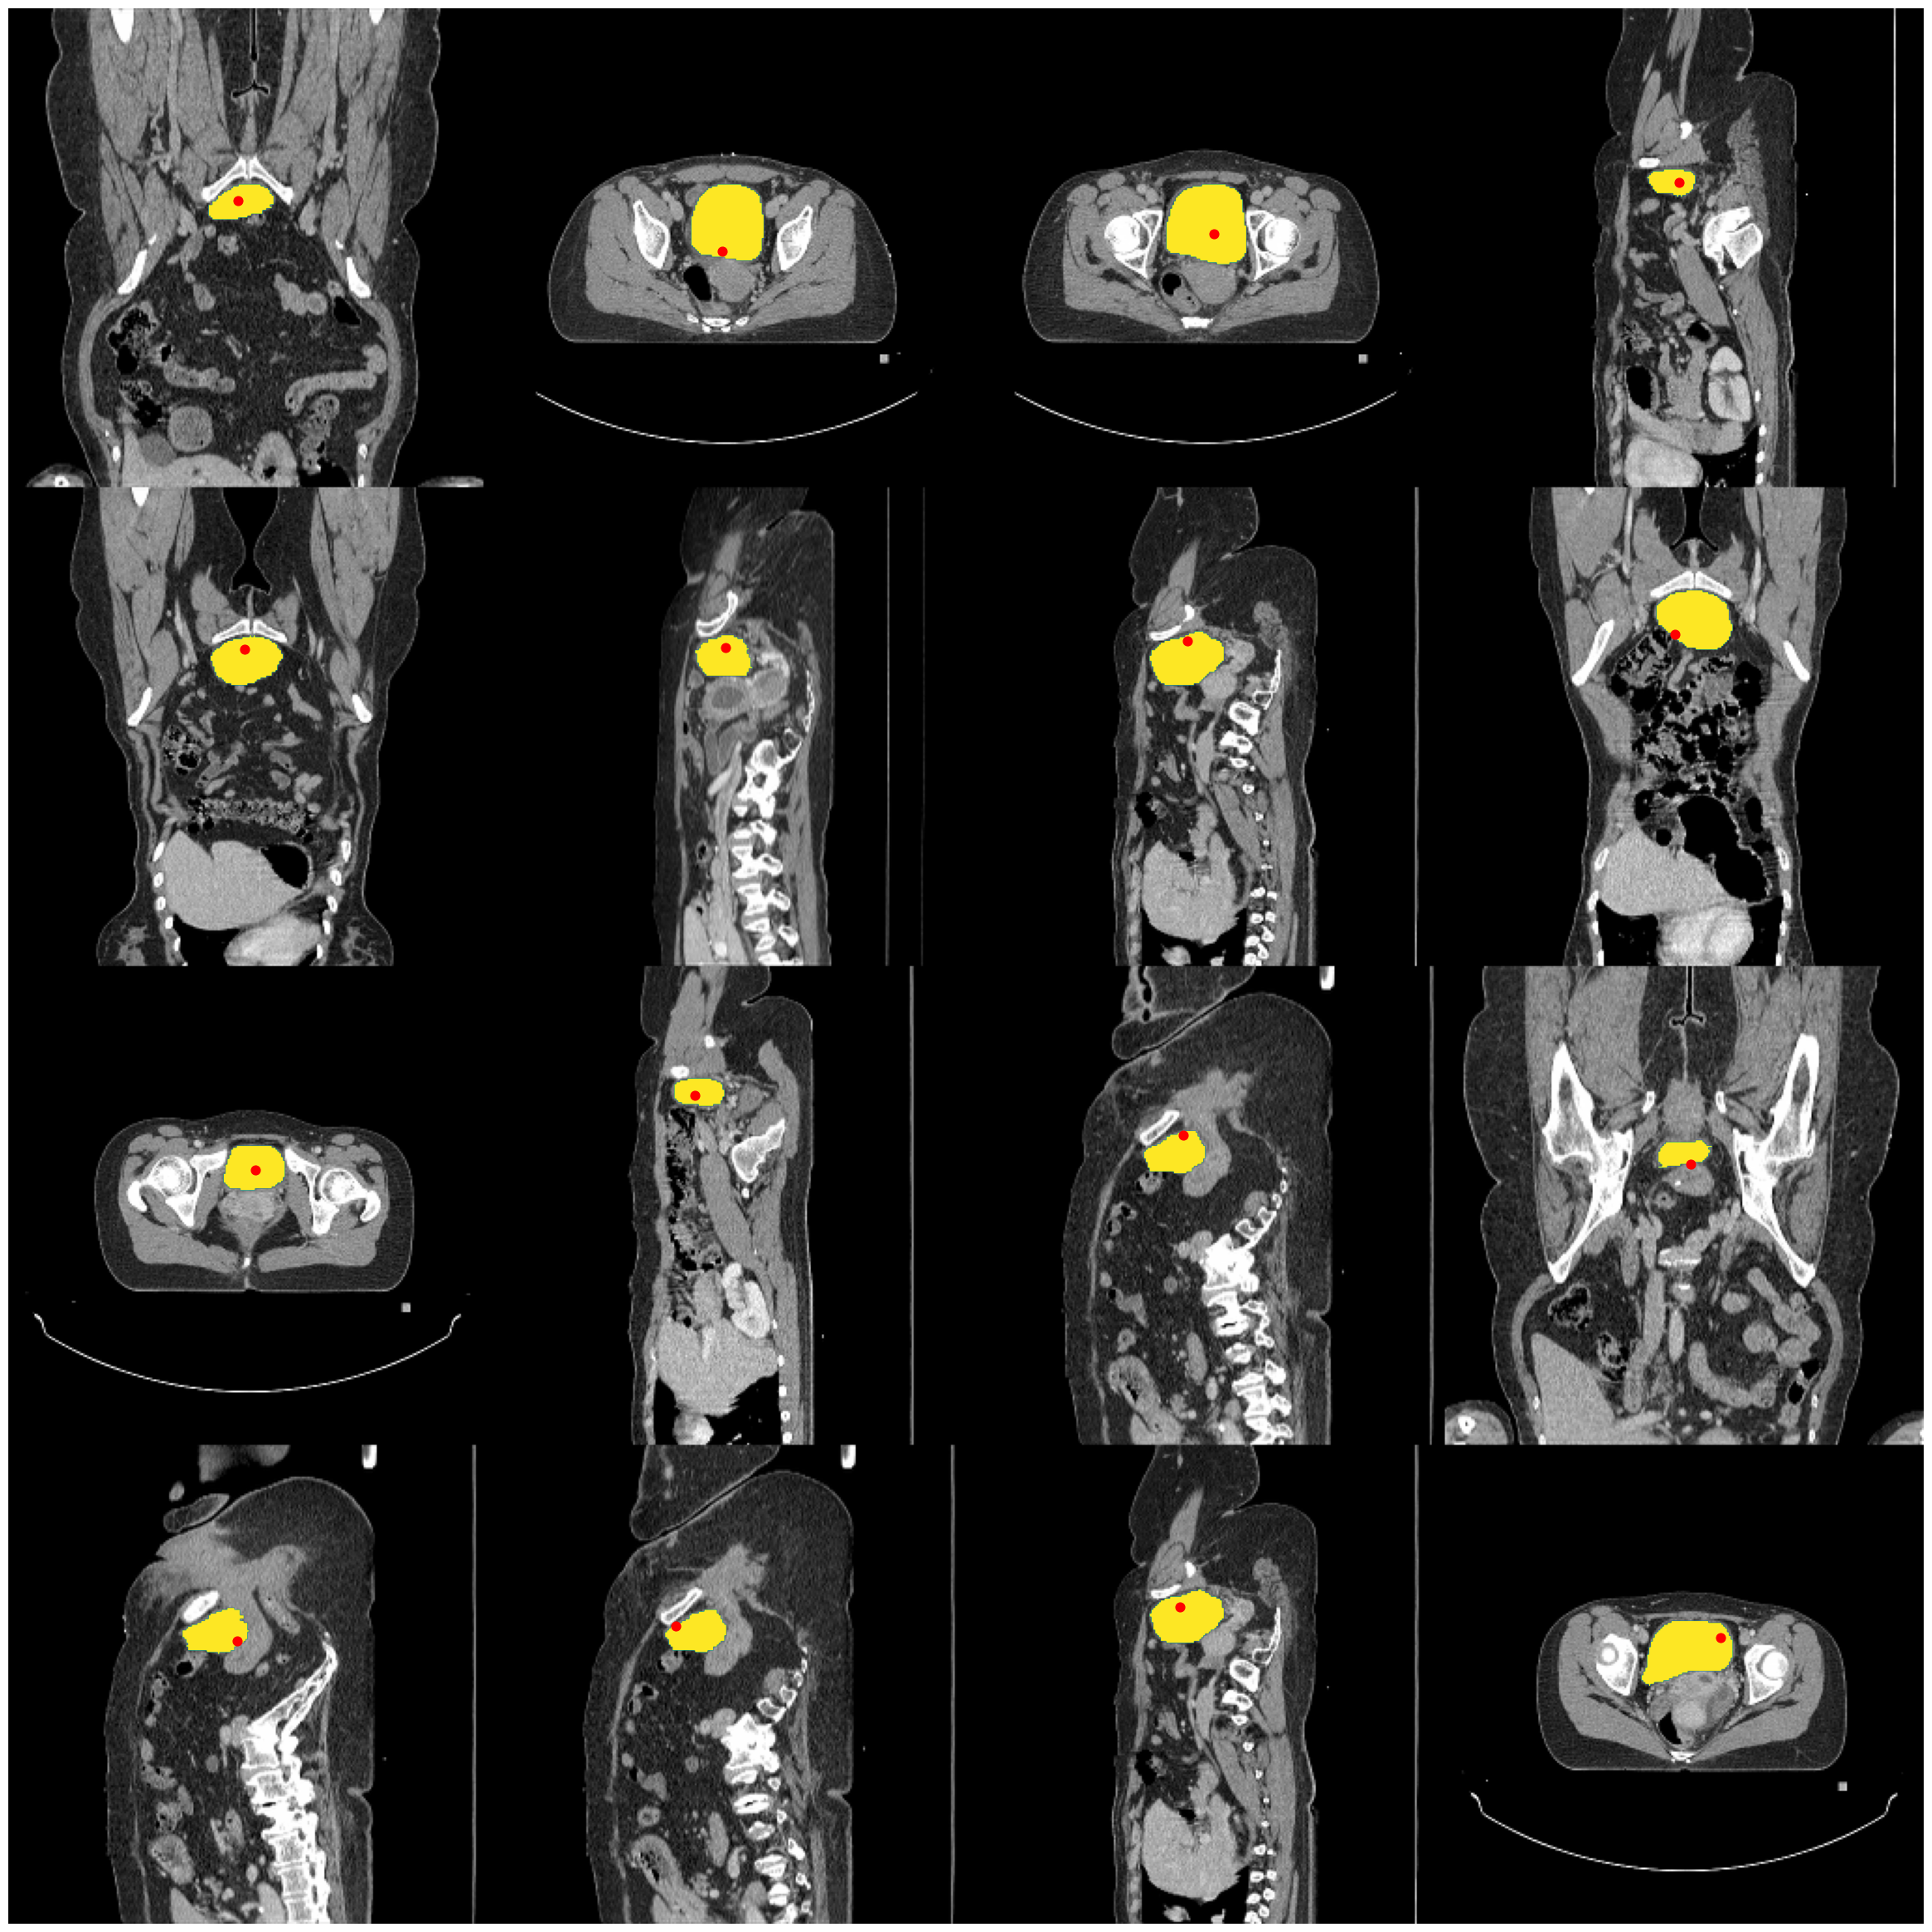

In [234]:
# quick test to see if the points are being generated correctly and transformations are also ok

from torchvision.utils import make_grid
import torch.nn.functional as F

experimental_datset = SAM_Dataset(img_dir, gt_dir, [1,2,3,4,5], data_aug=False)
dataloader = torch.utils.data.DataLoader(experimental_datset, batch_size=16, shuffle=True)

# Get a batch of examples
batch = next(iter(dataloader))

images = F.interpolate(batch['image'], size=(256, 256), mode='bilinear', align_corners=False)

grid_imgs = make_grid(images, nrow=4, padding=0)
grid_gts = make_grid(batch['gt2D'].float(), nrow=4, padding=0)
gts_mask = (grid_gts.sum(dim=0) > 0).float()

plt.figure(figsize=(30, 30))
plt.imshow(grid_imgs.permute(1, 2, 0))
plt.imshow(gts_mask, alpha=gts_mask, cmap='viridis')

shift_x = 0
shift_y = -256
for i in range(16):

    shift_y = shift_y + 256 if i % 4 == 0 else shift_y
    shift_x = shift_x + 256 if i % 4 != 0 else 0

    coord = batch['coords'][i].squeeze().numpy()
    x, y = coord[0], coord[1]
    x, y = x * 256 / 1024 + shift_x, y * 256 / 1024 + shift_y
    plt.scatter(x, y, c='r', s=60)

plt.axis('off')
plt.show()

## Set up Fine-Tuning nn Module

In [235]:
class MedSAM(nn.Module):
    def __init__(self, 
                image_encoder, 
                mask_decoder,
                prompt_encoder,
                freeze_image_encoder=False,
                ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder

        # freeze prompt encoder
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False
        
        self.freeze_image_encoder = freeze_image_encoder
        if self.freeze_image_encoder:
            for param in self.image_encoder.parameters():
                param.requires_grad = False

    def forward(self, image, point_prompt):

        # do not compute gradients for pretrained img encoder and prompt encoder
        with torch.no_grad():
            image_embedding = self.image_encoder(image) # (B, 256, 64, 64)
            # not need to convert box to 1024x1024 grid
            # bbox is already in 1024x1024
            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=point_prompt,
                boxes=None,
                masks=None,
            )
        low_res_masks, iou_predictions = self.mask_decoder(
            image_embeddings=image_embedding, # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          ) # (B, 1, 256, 256)

        return low_res_masks

## Setup logger for viewing progress

In [236]:
class MedSAMLogger(object):
    """The purpose of this class is to log the training process of the MedSAM model in a
    format that can be easily visualized."""

    " - start_epoch - this will start recording the per-batch loss for this new epoch, also records start time"
    
    " - end_epoch - this will end the recording of the per-batch loss for this epoch, also records end time. This will return and store the reduced loss as well as the duration for the epoch."

    def __init__(self, save_dir):
        epoch_stats_template = {
            'train_loss': [],
            'train_dice': [],
            'train_loss_reduced': -1,
            'train_dice_reduced': -1,
            'val_loss': [],
            'val_dice': [],
            'val_loss_reduced': -1,
            'val_dice_reduced': -1,
            'epoch_time': {
                'start': -1,
                'end': -1,
                'duration': 0
            }
        }

        # attempt to create a logger.json file if it doesn't already exist. If it does,
        # assume that we are resuming training
        if not os.path.exists(os.path.join(save_dir, 'logger.json')):
            self._load_logger()
        else:
            self.epoch_data = {
                'epoch': 0,
                'epoch_stats': epoch_stats_template
            }
        


    def log_train(self, loss, dice):
        self.train_loss.append(loss)
        self.train_dice.append(dice)

    def log_val(self, loss, dice):
        self.val_loss.append(loss)
        self.val_dice.append(dice)    

    def start_of_epoch(self):
        """initialize the loss and dice lists for the epoch"""
        self.train_loss = []
        self.train_dice = []

        self.val_loss = []
        self.val_dice = []

    def end_of_epoch(self):
        """calculate the epoch time and the average of the losses and dice scores"""


    def log_epoch_time(self, time):
        self.epoch_time.append(time)


## Helper Classes

In [242]:
class CheckpointHandler():
    def __init__(
            self,
            save_frequency: int,
            save_dir: str,
    ):
        
        self.save_frequency = save_frequency
        self.save_dir = save_dir

    def save_checkpoint(self, model, optimizer, epoch, epoch_loss, best_loss, final):
        """
        Will be guaranteed to save the checkpoint in the save_dir location. If the model
        is at peak performance, it saves it under 'checkpoint_best' otherwise, by default
        it is 'checkpoint_latest'. If specified, the checkpoint is saved under its final
        form and thus replaces 'checkpoint_latest' -> 'checkpoint_final'.
        """

        checkpoint = {
            "model": model.state_dict(),
            "epochs": epoch,
            "optimizer": optimizer.state_dict(),
            "loss": epoch_loss,
            "best_loss": best_loss
        }

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(checkpoint, os.path.join(self.save_dir, 'checkpoint_best.pth'))

        if final:
            torch.save(checkpoint, os.path.join(self.save_dir, 'checkpoint_final.pth'))
            os.remove(os.path.join(self.save_dir, 'checkpoint_latest.pth'))
        else:
            torch.save(checkpoint, os.path.join(self.save_dir, 'checkpoint_latest.pth'))

        return best_loss

    def load_checkpoint(self, model, optimizer):
        """
        Loads a checkpoint from the save_dir directory. Assumes this function will be called in the context of continuing training that hasn't finished yet.
        """
        checkpoint = torch.load(os.path.join(self.save_dir, 'checkpoint_latest.pth'))

        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch = checkpoint['epochs']
        best_loss = checkpoint['best_loss']

        return model, optimizer, epoch, best_loss

    def checkpoint_exists(self):
        return os.path.exists(os.path.join(self.save_dir, 'checkpoint_latest.pth'))

    def final_checkpoint_exists(self):
        return os.path.exists(os.path.join(self.save_dir, 'checkpoint_final.pth')) 

In [243]:
class DataLoaderHandler():
    def __init__(self, save_dir, image_dir, gt_dir, training_split = 0.8, validation_split = 0.2):
        # Where to save the data splits
        self.save_dir = save_dir
        
        # Where to get image and ground truth info for training
        self.image_dir = image_dir
        self.gt_dir = gt_dir
        
        # Splits for validation and training
        assert training_split + validation_split == 1
        self.training_split = training_split
        self.validation_split = validation_split

        # Final dataLoaders
        self.train_loader = None
        self.val_loader = None

    def save_splits_to_json(self, training_image_ids, validation_image_ids):

        data = {
            "training_image_ids": list(training_image_ids),
            "validation_image_ids": list(validation_image_ids)
        }
        with open(os.path.join(self.save_dir, 'data_splits.json'), 'w') as json_file:
            json.dump(data, json_file)

    def load_split_from_json(self):

        with open(os.path.join(self.save_dir, 'data_splits.json'), 'r') as json_file:
            data = json.load(json_file)
        self.training_split = set(data["training_image_ids"])
        self.validation_split = set(data["validation_image_ids"])

    def try_setup_data_split_from_save_with_fallback(self):

        # either load datasplits or setup anew
        if os.path.exists(os.path.join(self.save_dir, 'data_Splits.json')):
            self.load_split_from_json()
        else:
            self.setup_new_data_splits()

    def setup_new_data_splits(self):
        """Setup the data splits from scratch and save"""

        # get the image ids that have been processed. Use gt dir as reference
        axis0_slices = set(map(lambda x : int(re.search(image_id_from_file_name_regex, x).group(1)), os.listdir(os.path.join(self.gt_dir, 'axis0'))))
        axis1_slices = set(map(lambda x : int(re.search(image_id_from_file_name_regex, x).group(1)), os.listdir(os.path.join(self.gt_dir, 'axis1'))))
        axis2_slices = set(map(lambda x : int(re.search(image_id_from_file_name_regex, x).group(1)), os.listdir(os.path.join(self.gt_dir, 'axis2'))))

        if not axis0_slices == axis1_slices == axis2_slices:
            print('[WARNING]: The slices for the anatomy are not consistent across the three axes. Some axese are missing data, please check')
        
        # Split the data into training and validation
        self.training_image_ids = random.sample(list(axis0_slices), int(len(axis0_slices) * self.training_split))
        self.validation_image_ids = list(set(axis0_slices) - set(self.training_image_ids))
        assert set.intersection(set(self.training_image_ids), set(self.validation_image_ids)).__len__() == 0, 'Training and Validation sets are not disjoint'

        # Save the splits in a json file
        self.save_splits_to_json(self.training_image_ids, self.validation_image_ids)

    def setup_dataloaders(self):
        
        self.training_dataset = SAM_Dataset(self.image_dir, self.gt_dir, self.training_image_ids, data_aug = self.data_aug)
        self.validation_dataset = SAM_Dataset(self.image_dir, self.gt_dir, self.validation_image_ids, data_aug = self.data_aug)
        
        # Quick check
        assert set(map(lambda x : int(re.search(image_id_from_file_name_regex, x).group(1)), self.validation_dataset.axis0_imgs)) == set(self.validation_image_ids), 'DataSet incorrectly loaded image ids that don\'t match supplied validation set image ids'
        assert set(map(lambda x : int(re.search(image_id_from_file_name_regex, x).group(1)), self.training_dataset.axis0_imgs)) == set(self.training_image_ids), 'DataSet incorrectly loaded image ids that don\'t match supplied validation set image ids'

        self.train_loader = DataLoader(self.training_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)
        self.val_loader = DataLoader(self.validation_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)


    

In [ ]:
class LoggingHandler():
    def __init__(self, save_dir):
        # idea, just have a dictionary with the stats that you save at the end of each
        # epoch. You save it down to json at the end. On start, you create a new logging
        # text file where you have info about the running script. IF there doesn't exist a
        # file 'checkpoint_latest_stats.json' then create one. This is where you will load
        # up the stats from the previous run. If there is no such file, then you start
        # from scratch.

        self.per_epoch_stats = dict()
        self.save_dir = save_dir
        self.curr_epoch = -1
        self.curr_epoch_stats = dict()

        # check if the file exists
        if os.path.exists(os.path.join(save_dir, 'checkpoint_latest_stats.json')):
            self.load_stats()
        else:
            self.save_stats()

    def save_stats(self):
        with open(os.path.join(self.save_dir, 'checkpoint_latest_stats.json'), 'w') as json_file:
            json.dump(self.per_epoch_stats, json_file)

    def load_stats(self):
        with open(os.path.join(self.save_dir, 'checkpoint_latest_stats.json'), 'r') as json_file:
            self.per_epoch_stats = json.load(json_file)

    def log(self, key, value, epoch):
        assert self.curr_epoch == epoch
        self.curr_epoch_stats[key].append(value)

    def start_new_epoch(self, epoch):
        self.save_stats()
        self.per_epoch_stats[self.curr_epochs] = self.curr_epoch_stats
        self.curr_epoch = epoch
        self.curr_epoch_stats = {}
    

## Main Training Loop

In [238]:
import logging

logging.basicConfig(
    filename=os.path.join(save_dir, 'MedSAM_training.log'), 
    filemode='w',
    format='[%(levelname)s : %(asctime)s] - %(message)s',
    datefmt='%d-%b-%y %H:%M:%S',
    level=logging.DEBUG
)

# logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

logging.debug('Set up logger! Happy Debugging!')

In [239]:
class MedSAMTrainer(object):
    def __init__(self
                , anatomy
                , checkpoint_path
                , save_dir
                , image_dir
                , gt_dir
                , epochs
                , batch_size
                , lr
                , num_workers
                , weight_decay
                , resume
                , device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                , ):
        
        self.anatomy = anatomy
        assert self.anatomy in ['CTVn', 'CTVp', 'Bladder', 'Anorectum', 'Uterus', 'Vagina']
        
        self.image_dir = image_dir
        self.gt_dir = gt_dir
        assert os.path.exists(self.image_dir), 'Image Directory doesn\'t exist.'
        assert os.path.exists(self.gt_dir), 'Ground Truth Directory doesn\'t exist for the requested anatomy.'

        self.save_dir = save_dir
        self.checkpoint_path = checkpoint_path
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.num_workers = num_workers
        self.weight_decay = weight_decay
        self.resume = resume
        self.device = device

        

        # self.stat_logger = MedSAMLogger(self.save_dir)

    def run_training(self):
        """Main Training Loop"""

        logging.debug('Entered main training loop')
        self.on_train_start()

        for epoch in range(self.start_epoch, self.epochs):
            # <Training>
            self.on_epoch_start(epoch)

            pbar = tqdm(self.train_loader)
            for step, batch in enumerate(pbar):
                dice_loss, ce_loss = self.train_step(step, batch)

                # self.stat_logger.log_train(dice_loss, ce_loss)

                pbar.set_description(f"Epoch {epoch} at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, loss: {dice_loss + ce_loss:.4f}")

            self.on_epoch_end()
            # </Training>

            # # <Validation>
            # with torch.no_grad():
            #     self.medsam_model.eval()
            #     for step, batch in enumerate(self.val_loader):
            #         image = batch["image"].to(self.device)
            #         gt2D = batch["gt2D"].to(self.device)
            #         coords_torch = batch["coords"].to(self.device)
            # # </Validation>

        self.on_train_end()

    def train_step(self, step, batch):
        logging.debug(f'Starting epoch {self.current_epoch} step {step} at time {datetime.now()}')

        # Get data
        logging.debug('getting the data and setting to device')
        image = batch["image"].to(self.device)
        gt2D = batch["gt2D"].to(self.device)
        coords_torch = batch["coords"].to(self.device) # (B, 2)

        logging.debug('Performing forward pass')
        self.optimizer.zero_grad()
        labels_torch = torch.ones(coords_torch.shape[0]).long() # (B,)
        labels_torch = labels_torch.unsqueeze(1) # (B, 1)
        coords_torch, labels_torch = coords_torch.to(self.device), labels_torch.to(self.device)
        point_prompt = (coords_torch, labels_torch)
        medsam_lite_pred = self.medsam_model(image, point_prompt)

        logging.debug('Calculating loss')
        dice_loss = self.dice_loss(medsam_lite_pred, gt2D)
        ce_loss = self.ce_loss(medsam_lite_pred, gt2D.float())

        loss = dice_loss + ce_loss
        logging.debug(f'Loss calculated: {loss.item()}')
        
        logging.debug('Performing step in optimizer and propagating loss backgwards')
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        # self.stat_logger.log_train(dice_loss.item(), ce_loss.item())

        return dice_loss.item(), ce_loss.item()
    
    def on_train_end(self):
        logging.debug(f'Reached the end of training! Epochs: {self.epochs}')
        self.save_checkpoint(self.current_epoch, self.epoch_loss, final=True)
        torch.cuda.empty_cache()

    def on_epoch_end(self):
        # epoch_time, epoch_los_reduced = self.stat_logger.end_of_epoch(self.current_epoch)

        self.epoch_end_time = time()
        self.epoch_time.append(self.epoch_end_time - self.epoch_start_time)
        logging.debug(f'Reached the end of epoch {self.current_epoch}, it took {self.epoch_end_time - self.epoch_start_time} seconds')

        epoch_loss_reduced = sum(self.epoch_loss) / len(self.epoch_loss)

        self.save_checkpoint(self.current_epoch, epoch_loss_reduced)

        # Plot the progress

        # self.print_to_log_file('train_loss', np.round(logging.my_fantastic_logging['train_losses'][-1], decimals=4))
        # self.print_to_log_file('val_loss', np.round(logging.my_fantastic_logging['val_losses'][-1], decimals=4))
        # self.print_to_log_file('Pseudo dice', [np.round(i, decimals=4) for i in
        #                                        logging.my_fantastic_logging['dice_per_class_or_region'][-1]])
        # self.print_to_log_file(
        #     f"Epoch time: {np.round(logging.my_fantastic_logging['epoch_end_timestamps'][-1] - logging.my_fantastic_logging['epoch_start_timestamps'][-1], decimals=2)} s")

        # logging.plot_progress_png(self.save_dir)

    def on_train_start(self):
        """Sets up the training environment"""
        logging.debug('starting training environment')

        # empty cuda cache
        torch.cuda.empty_cache()

        # create save_dir if it doesn't exist yet
        os.makedirs(self.save_dir, exist_ok=True)

        # set up logger to a new instance
        # logging = MedSAMLogger()

        # load the previous checkpoint if it exists and resume is True. Otherwise, load
        # the medSAM model from which we train. 
        self._first_run_setup()
        if (not self._maybe_load_checkpoint()):
            self._setup_data_splits()

        # set up the dataloaders
        self._get_dataloaders()

        # set up loss functions
        logging.debug('Setting up loss functions')
        self.dice_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')
        self.ce_loss = nn.BCEWithLogitsLoss(reduction="mean")

    def on_epoch_start(self, epoch):        
        self.medsam_model.train()
        self.current_epoch = epoch
        self.epoch_start_time = datetime.now()
        self.epoch_loss = [1e10 for _ in range(len(self.train_loader))]

        # self.stat_logger.start_epoch(epoch, epoch_start_time)

        logging.debug(f'>> Starting epoch {epoch} at time {self.epoch_start_time}')

    def _maybe_load_checkpoint(self):
        """
        Populates the variables IF a checkpoint has been found
        - checkpoint
        - medsam_model
        - optimizer
        - start_epoch
        - best_loss
        - training_split
        - validation_split
        """
        logging.debug('Attempting to find and load checkpoint from save directory')
        if not self.resume:
            logging.debug('Resume was set to false, skipping checkpoint loading.')
            return False

        if len([f for f in os.listdir(save_dir) if f == 'checkpoint_latest.pth']) == 0:
            logging.debug('No checkpoint found in the save directory')
            return False
        
        # Load model details
        logging.debug('found and loading checkpoint from checkpoint_latest.pth')
        self.checkpoint = torch.load(os.path.join(save_dir, 'checkpoint_latest.pth'))

        self.medsam_model.load_state_dict(self.checkpoint["model"])
        self.optimizer.load_state_dict(self.checkpoint["optimizer"])
        self.start_epoch = self.checkpoint["epoch"] + 1
        self.best_loss = self.checkpoint["best_loss"]
        logging.debug(f"Loaded checkpoint from epoch {self.start_epoch}, best loss: {self.best_loss:.4f}")

        # Get Data Split
        try:
            self._load_split_from_json()
        except FileNotFoundError as e:
            logging.debug('[WARNING] a checkpoint was found, but a split file was not.')
            logging.debug('          a new data split will be generated with potential training bias towards the validaiton split.')
            self._setup_data_splits()

        return True  

    def _first_run_setup(self):
        logging.debug('running setup for sam model at base checkpoint')
        sam_model = sam_model_registry["vit_b"](checkpoint=self.checkpoint_path)
        self.medsam_model = MedSAM(
            image_encoder = sam_model.image_encoder,
            mask_decoder = sam_model.mask_decoder,
            prompt_encoder = sam_model.prompt_encoder,
            freeze_image_encoder = True
        )
        self.medsam_model = self.medsam_model.to(self.device)

        logging.debug('setting up optimizer for sam model at base checkpoint')
        self.optimizer = optim.AdamW(
            self.medsam_model.mask_decoder.parameters(),
            lr=self.lr,
            betas=(0.9, 0.999),
            eps=1e-08,
            weight_decay=self.weight_decay
        )

        self.start_epoch = 0
        self.best_loss = float('inf')

In [240]:
trainer = MedSAMTrainer(
    anatomy
    , checkpoint_path
    , save_dir
    , img_dir
    , gt_dir
    , epochs
    , batch_size
    , lr
    , num_workers
    , weight_decay
    , resume
)

In [241]:
trainer.run_training()

  0%|          | 0/1052 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 GiB. GPU 